In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import shutil
import cv2
import albumentations as A
import os
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import plotly.graph_objs as go
from keras.layers import Input
import tensorflow as tf
from keras.applications.xception import Xception
from keras import layers
from keras.models import Model
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')

### **Loading imbalanced Ham1000 dataset**

In [11]:
skin_dir = os.path.join('/', 'kaggle/input/')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

skinDf = pd.read_csv(os.path.join(skin_dir, 'HAM10000_metadata.csv'))
skinDf['path'] = skinDf['image_id'].map(imageid_path_dict.get)
skinDf['cell_type'] = skinDf['dx'].map(lesion_type_dict.get) 
skinDf['label'] = pd.Categorical(skinDf['cell_type']).codes
skinDf.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,label
7214,HAM_0007444,ISIC_0032977,nv,histo,50.0,female,lower extremity,/kaggle/input/ham10000_images_part_2/ISIC_0032...,Melanocytic nevi,4
3762,HAM_0001339,ISIC_0026201,nv,follow_up,5.0,male,trunk,/kaggle/input/ham10000_images_part_1/ISIC_0026...,Melanocytic nevi,4
4460,HAM_0006388,ISIC_0029542,nv,follow_up,65.0,male,trunk,/kaggle/input/ham10000_images_part_2/ISIC_0029...,Melanocytic nevi,4


In [12]:
df = pd.DataFrame()         # only 2 columns: ["filepaths", "labels"]
df['filepaths'] =skinDf['path']
df['label'] =skinDf['label']
df['label'] =df['label'].apply(lambda x: str(x))
df.head()

,filepaths,label
0,/kaggle/input/ham10000_images_part_1/ISIC_0027...,2
1,/kaggle/input/ham10000_images_part_1/ISIC_0025...,2
2,/kaggle/input/ham10000_images_part_1/ISIC_0026...,2
3,/kaggle/input/ham10000_images_part_1/ISIC_0025...,2
4,/kaggle/input/ham10000_images_part_2/ISIC_0031...,2


In [14]:
def plot_label_count (df, plot_title):
    column='label'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()    
    values=vcounts.tolist() 
    lcount=len(labels)
    if lcount>55:
        print_in_color('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5)) 
        form = {'family': 'serif', 'color': 'blue', 'size': 25} 
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='yellow', ha='center')        
        plt.show()

label
4    6705
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


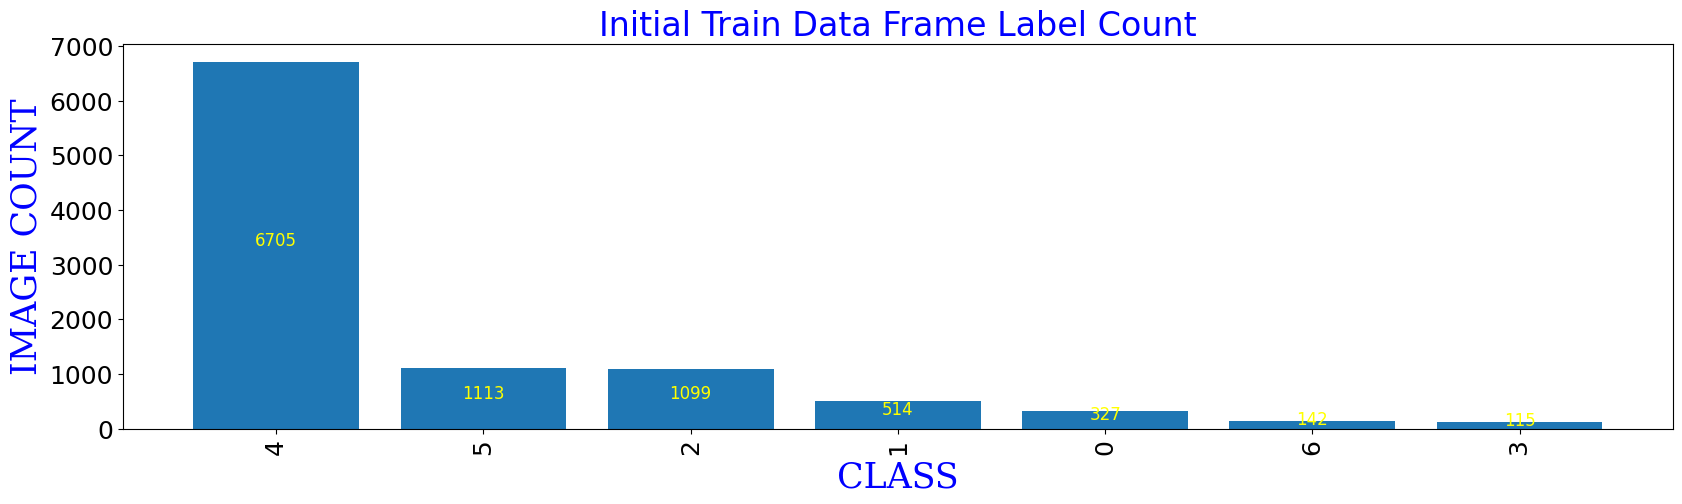

In [15]:
print(df['label'].value_counts())
plot_label_count (df, "Initial Train Data Frame Label Count")

### **Balancing the imbalanced Ham10000 dataset**

In [16]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes= df[column].unique()
    print(classes)
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count


max_samples=6000
min_samples= 10
column='label'

df, classes, class_count= trim(df, max_samples, min_samples, column)

count=df['label'].value_counts()
print (count)

['2' '4' '3' '5' '6' '1' '0']
dataframe initially is of length  10015  with  7  classes
after trimming, the maximum samples in any class is now  6000  and the minimum samples in any class is  10
the trimmed dataframe now is of length  9310  with  7  classes
label
4    6000
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [17]:
def balance(df, n,column, working_dir):
    def get_augmented_image(image):
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])    
        return transform(image=image)['image']
    
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')   # directory to store augmented images
    
    if os.path.isdir(aug_dir):                 # start with an empty directory
        shutil.rmtree(aug_dir)
        
    os.mkdir(aug_dir)        
    
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)                    # make class directories within aug directory
    
    # create and store the augmented images  
    total=0    
    groups=df.groupby(column)                # group by class
    for label in df[column].unique():        # for every class               
        group=groups.get_group(label)        # a dataframe holding only rows with the specified label 
        sample_count=len(group)              # determine how many samples there are in this class  
        if sample_count < n:                 # if the class has less than target number of images
            aug_img_count=0
            delta = n - sample_count         # number of augmented images to generate
            target_dir=os.path.join(aug_dir, label)  # define where to write the images            
            desc=f'augmenting class {label}'
            for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
                j= i % sample_count
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)                
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='label')   
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    df = df.sample(frac=1).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=6000
working_dir=r'/kaggle/working/'
column='label'

balanced_df = balance(df, n, column, working_dir)

Initial length of dataframe is  9310


augmenting class 2:   0%|                                                                   | 0/4901 [00:00<?,…

augmenting class 3:   0%|                                                                   | 0/5885 [00:00<?,…

augmenting class 5:   0%|                                                                   | 0/4887 [00:00<?,…

augmenting class 6:   0%|                                                                   | 0/5858 [00:00<?,…

augmenting class 1:   0%|                                                                   | 0/5486 [00:00<?,…

augmenting class 0:   0%|                                                                   | 0/5673 [00:00<?,…

Total Augmented images created=  32690
Length of augmented dataframe is now  42000


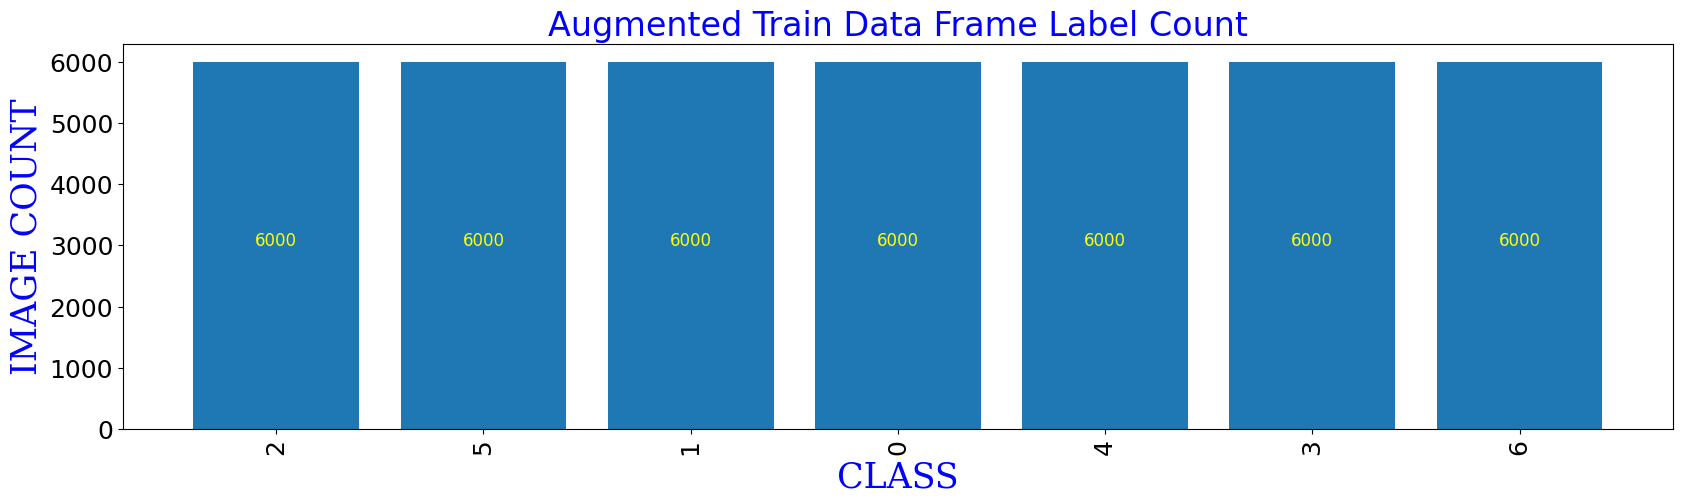

In [19]:
plot_label_count (balanced_df, "Augmented Train Data Frame Label Count")

In [20]:
def resize_and_convert(filepath):
  img = Image.open(filepath)
  resized_img = img.resize((76, 76))
  return np.asarray(resized_img)

balanced_df['image'] = [resize_and_convert(path) for path in balanced_df["filepaths"]]

In [21]:
balanced_df.head()

,filepaths,label,image
0,/kaggle/working/aug/2/aug4782-ISIC_0026159.jpg,2,"[[[221, 188, 181], [220, 187, 180], [220, 189,..."
1,/kaggle/working/aug/5/aug4106-ISIC_0031666.jpg,5,"[[[156, 116, 132], [168, 122, 130], [174, 124,..."
2,/kaggle/working/aug/1/aug5171-ISIC_0028693.jpg,1,"[[[163, 156, 164], [167, 160, 167], [170, 164,..."
3,/kaggle/working/aug/0/aug400-ISIC_0031940.jpg,0,"[[[157, 105, 100], [164, 113, 112], [165, 115,..."
4,/kaggle/working/aug/1/aug808-ISIC_0032174.jpg,1,"[[[219, 198, 198], [220, 197, 194], [218, 192,..."


In [22]:
x=np.asarray(balanced_df['image'].to_list())

y=balanced_df['label']
y=to_categorical(y, num_classes=7)

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True)  # 0.25 x 0.8 = 0.2

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

x_train shape: (25200, 76, 76, 3) - y_train shape: (25200, 7)
x_test shape: (8400, 76, 76, 3) - y_test shape: (8400, 7)
x_val shape: (8400, 76, 76, 3) - y_val shape: (8400, 7)


In [23]:
train_y = y_train
test_y = y_test
val_y = y_val
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)
y_val = np.argmax(y_val, axis=1)

# Ensure data type is float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

# Normalize the pixel values to the range [0, 1]
x_train /= 255.0
x_test /= 255.0
x_val /= 255.0

# resize images to 96x96
x_train = np.array([resize(image, (96, 96)) for image in x_train])
x_test = np.array([resize(image, (96, 96)) for image in x_test])
x_val = np.array([resize(image, (96, 96)) for image in x_val])

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

x_train shape: (25200, 96, 96, 3) - y_train shape: (25200,)
x_test shape: (8400, 96, 96, 3) - y_test shape: (8400,)
x_val shape: (8400, 96, 96, 3) - y_val shape: (8400,)


In [24]:
num_classes=7
batch_size = 32
classes = ['aklec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
input_shape = (96, 96, 3)
input_layer = Input(shape=input_shape)

In [25]:
from plotly.subplots import make_subplots
def plot_images(df, indices, width=200, height=200):
    num_images = len(indices)
    size = (128, 128)
    images = [Image.fromarray(df['image'].iloc[i]).resize(size) for i in indices]
    images = [np.array(img) for img in images]

    fig = make_subplots(rows=1, cols=num_images, subplot_titles=[f"{classes[int(df['label'].iloc[i])]}" for i in indices])

    for i, img in enumerate(images, start=1):
        fig.add_trace(go.Image(z=img), row=1, col=i)

    fig.update_layout(
        width=width*num_images,  # Adjust the total width of the plot
        height=height,
        margin=dict(l=10, r=10, t=45, b=20),
    )

    fig.show()
    
plot_images(balanced_df, [1, 2, 3, 8])
plot_images(balanced_df, [9, 17, 29])

### **Xception Model**

In [26]:
xception_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in xception_model.layers:
    layer.trainable = True

x = xception_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_xception_model = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_xception = Model(inputs=input_layer, outputs=output_xception_model)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
# Compile the model
model_xception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Train the model
history_xception = model_xception.fit(
    x_train,
    y_train,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/30
  1/788 ━━━━━━━━━━━━━━━━━━━━ 11:11:34 51s/step - accuracy: 0.1875 - loss: 1.9843

I0000 00:00:1717517665.844543     156 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717517665.916488     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6398 - loss: 0.9871

W0000 00:00:1717517757.245344     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717517762.815956     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717517770.756217     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


788/788 ━━━━━━━━━━━━━━━━━━━━ 156s 133ms/step - accuracy: 0.6399 - loss: 0.9868 - val_accuracy: 0.7331 - val_loss: 0.9644 - learning_rate: 0.0010
Epoch 2/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - accuracy: 0.8490 - loss: 0.4108 - val_accuracy: 0.8525 - val_loss: 0.4312 - learning_rate: 0.0010
Epoch 3/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - accuracy: 0.9030 - loss: 0.2682 - val_accuracy: 0.7906 - val_loss: 0.6914 - learning_rate: 0.0010
Epoch 4/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - accuracy: 0.9282 - loss: 0.2013 - val_accuracy: 0.8413 - val_loss: 0.5304 - learning_rate: 0.0010
Epoch 5/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - accuracy: 0.9469 - loss: 0.1572 - val_accuracy: 0.8760 - val_loss: 0.4104 - learning_rate: 0.0010
Epoch 6/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - accuracy: 0.9649 - loss: 0.1045 - val_accuracy: 0.7896 - val_loss: 0.8177 - learning_rate: 0.0010
Epoch 7/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - accuracy: 0.9681 - loss: 0.09

In [28]:
# Evaluate the model
print("\nEvaluate in test dataset:")
model_xception.evaluate(x_test, y_test)


Evaluate in test dataset:
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9463 - loss: 0.2295


[0.21317194402217865, 0.947857141494751]

### **InceptionResnetV2 Model**

In [29]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

inception_resnet_v2_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in inception_resnet_v2_model.layers:
    layer.trainable = True

x = inception_resnet_v2_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.4)(x)
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.4)(x)
output_inception_resnet_v2 = tf.keras.layers.Dense(7, activation='softmax')(x)

model_inception_resnet_v2 = Model(inputs=input_layer, outputs=output_inception_resnet_v2)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [30]:
# Compile the model
model_inception_resnet_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Train the model
history_inception_resnet_v2 = model_inception_resnet_v2.fit(
    x_train,
    y_train,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate the model
print("\nEvaluate in test dataset:")
model_inception_resnet_v2.evaluate(x_test, y_test)

Epoch 1/30
  1/788 ━━━━━━━━━━━━━━━━━━━━ 38:25:47 176s/step - accuracy: 0.2188 - loss: 2.2720

W0000 00:00:1717520233.047961     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6257 - loss: 1.1156

W0000 00:00:1717520408.644498     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717520423.168266     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717520437.062187     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


788/788 ━━━━━━━━━━━━━━━━━━━━ 381s 260ms/step - accuracy: 0.6258 - loss: 1.1155 - val_accuracy: 0.6138 - val_loss: 8.3654 - learning_rate: 0.0010
Epoch 2/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 97s 122ms/step - accuracy: 0.6667 - loss: 1.0191 - val_accuracy: 0.7906 - val_loss: 0.5681 - learning_rate: 0.0010
Epoch 3/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 96s 122ms/step - accuracy: 0.6798 - loss: 1.0188 - val_accuracy: 0.2725 - val_loss: 2.7355 - learning_rate: 0.0010
Epoch 4/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 96s 121ms/step - accuracy: 0.5451 - loss: 1.3832 - val_accuracy: 0.5956 - val_loss: 1.0653 - learning_rate: 0.0010
Epoch 5/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 96s 121ms/step - accuracy: 0.6243 - loss: 1.1707 - val_accuracy: 0.6163 - val_loss: 4.2949 - learning_rate: 0.0010
Epoch 6/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 96s 121ms/step - accuracy: 0.6907 - loss: 0.9894 - val_accuracy: 0.6143 - val_loss: 44.5976 - learning_rate: 0.0010
Epoch 7/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6064 - loss

[0.5798274278640747, 0.7916666865348816]

### **MobileNetV2 Model**

In [31]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet_v2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in mobilenet_v2_model.layers:
    layer.trainable = True

x = mobilenet_v2_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output_mobilenet_v2_model = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_mobilenet_v2 = Model(inputs=input_layer, outputs=output_mobilenet_v2_model)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
# Compile the model
model_mobilenet_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Train the model
history_mobilenet_v2 = model_mobilenet_v2.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate the model
print("\nEvaluate in test dataset:")
model_mobilenet_v2.evaluate(x_test, y_test)

Epoch 1/50
  3/788 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.1823 - loss: 2.3100    

W0000 00:00:1717522520.703050     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5805 - loss: 1.2047

W0000 00:00:1717522570.588057     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717522576.012858     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717522580.060892     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


788/788 ━━━━━━━━━━━━━━━━━━━━ 114s 76ms/step - accuracy: 0.5806 - loss: 1.2044 - val_accuracy: 0.1474 - val_loss: 9.9973 - learning_rate: 0.0010
Epoch 2/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.7627 - loss: 0.6720 - val_accuracy: 0.1744 - val_loss: 8.4817 - learning_rate: 0.0010
Epoch 3/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.8118 - loss: 0.5370 - val_accuracy: 0.1479 - val_loss: 15.0432 - learning_rate: 0.0010
Epoch 4/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.8357 - loss: 0.4697 - val_accuracy: 0.2407 - val_loss: 9.4137 - learning_rate: 0.0010
Epoch 5/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.8503 - loss: 0.4312 - val_accuracy: 0.4487 - val_loss: 5.0551 - learning_rate: 0.0010
Epoch 6/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.8788 - loss: 0.3488 - val_accuracy: 0.4063 - val_loss: 5.9594 - learning_rate: 0.0010
Epoch 7/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.8853 - loss: 0.33

[0.23641334474086761, 0.942976176738739]

### **Fuzzy Rank-based Ensemble Technique**

In [33]:
#Fuzzy Rank-based Ensemble:
def generateRank1(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1 - np.exp(-((scores[i]-1)**2)/2.0)
  return rank

def generateRank2(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1 - np.tanh(((scores[i]-1)**2)/2)
  return rank

def doFusion(res1, res2, res3, label, class_no):
    cnt = 0
    id = []
    for i in range(len(res1)):
        rank1 = generateRank1(res1[i], class_no) * generateRank2(res1[i], class_no)
        rank2 = generateRank1(res2[i], class_no) * generateRank2(res2[i], class_no)
        rank3 = generateRank1(res3[i], class_no) * generateRank2(res3[i], class_no)
        rankSum = rank1 + rank2 + rank3
        rankSum = np.array(rankSum)
        scoreSum = 1 - (res1[i] + res2[i] + res3[i]) / 3
        scoreSum = np.array(scoreSum)

        fusedScore = (rankSum.T) * scoreSum
        cls = np.argmin(rankSum)
        if cls<class_no and label[i][cls]== 1:  # Compare indices directly
            cnt += 1
        id.append(cls)
    print(cnt / len(res1))
    return id

In [34]:
pred_xception = model_xception.predict(x_test)
pred_inception_resnet_v2 = model_inception_resnet_v2.predict(x_test)
pred_mobilenet_v2 = model_mobilenet_v2.predict(x_test)
pred_ensembled = doFusion(pred_xception, pred_inception_resnet_v2,pred_mobilenet_v2, test_y, class_no=num_classes)

263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step
 19/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

W0000 00:00:1717523709.104152     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step


W0000 00:00:1717523713.697366     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


0.9514285714285714


### **Evaluation with Classification Report**

In [35]:
label_xception = np.argmax(pred_xception, axis=-1)
label_inception_resnet_v2 = np.argmax(pred_inception_resnet_v2, axis=-1)
label_mobilenet_v2 = np.argmax(pred_mobilenet_v2, axis=-1)

print('Xception base learner')
print(classification_report(y_test, label_xception, target_names=classes, digits=4))
print('InceptionResNetV2 base learner')
print(classification_report(y_test, label_inception_resnet_v2, target_names=classes, digits=4))
print('MobileNetV2 base learner')
print(classification_report(y_test, label_mobilenet_v2, target_names=classes, digits=4))
print('Ensembled')
print(classification_report(y_test, pred_ensembled, target_names=classes, digits=4))

Xception base learner
              precision    recall  f1-score   support

       aklec     0.9640    0.9647    0.9644      1276
         bcc     0.9568    0.9813    0.9689      1174
         bkl     0.9109    0.9078    0.9093      1182
          df     0.9941    0.9974    0.9957      1173
         mel     0.9222    0.8797    0.9004      1172
          nv     0.8900    0.9046    0.8972      1226
        vasc     0.9967    0.9992    0.9979      1197

    accuracy                         0.9479      8400
   macro avg     0.9478    0.9478    0.9477      8400
weighted avg     0.9477    0.9479    0.9477      8400

InceptionResNetV2 base learner
              precision    recall  f1-score   support

       aklec     0.8264    0.7500    0.7864      1276
         bcc     0.8446    0.8101    0.8270      1174
         bkl     0.5805    0.7445    0.6523      1182
          df     0.8583    0.9915    0.9201      1173
         mel     0.8462    0.6246    0.7187      1172
          nv     0.6782  

### **Evaluation with Confusion Matrix**

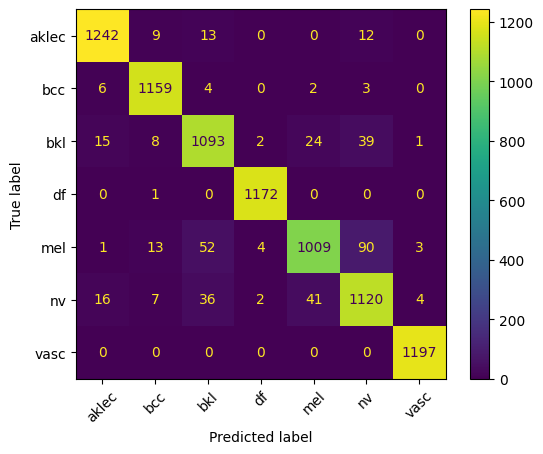

In [36]:
cm_ensembled = confusion_matrix(y_test, pred_ensembled)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensembled, display_labels=classes)
disp.plot(xticks_rotation=45)

### **Generate ROC Curve**

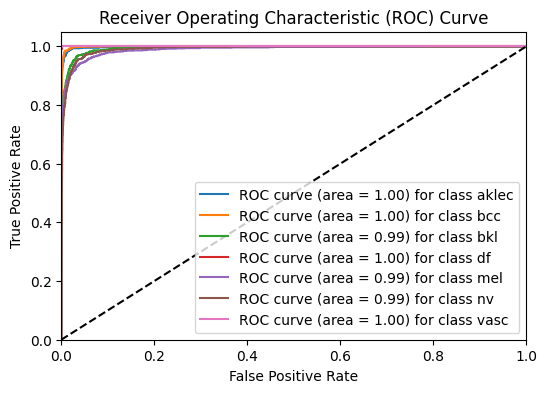

In [37]:
num_classes = 7

# Compute ROC curve and ROC area for each class
fpr_xception = dict()
tpr_xception = dict()
roc_auc_xception = dict()

# Assuming pred_xception contains probabilities and not one-hot encoded labels
for i in range(num_classes):
    fpr_xception[i], tpr_xception[i], _ = roc_curve((y_test == i).astype(int), pred_xception[:, i])
    roc_auc_xception[i] = auc(fpr_xception[i], tpr_xception[i])

# Plot ROC curve
plt.figure(figsize=(6, 4))

# Plot each class for Xception
for i in range(num_classes):
    plt.plot(fpr_xception[i], tpr_xception[i], label=f'ROC curve (area = {roc_auc_xception[i]:0.2f}) for class {classes[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

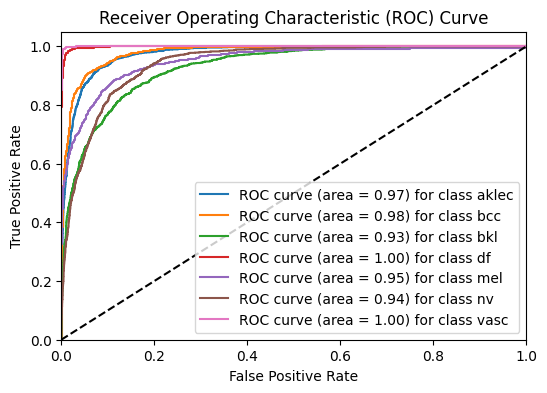

In [38]:
num_classes = 7

# Compute ROC curve and ROC area for each class
fpr_inception_resnet_v2 = dict()
tpr_inception_resnet_v2 = dict()
roc_auc_inception_resnet_v2 = dict()

# Assuming pred_xception contains probabilities and not one-hot encoded labels
for i in range(num_classes):
    fpr_inception_resnet_v2[i], tpr_inception_resnet_v2[i], _ = roc_curve((y_test == i).astype(int), pred_inception_resnet_v2[:, i])
    roc_auc_inception_resnet_v2[i] = auc(fpr_inception_resnet_v2[i], tpr_inception_resnet_v2[i])

# Plot ROC curve
plt.figure(figsize=(6, 4))

# Plot each class for inception_resnet_v2
for i in range(num_classes):
    plt.plot(fpr_inception_resnet_v2[i], tpr_inception_resnet_v2[i], label=f'ROC curve (area = {roc_auc_inception_resnet_v2[i]:0.2f}) for class {classes[i]}')

plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

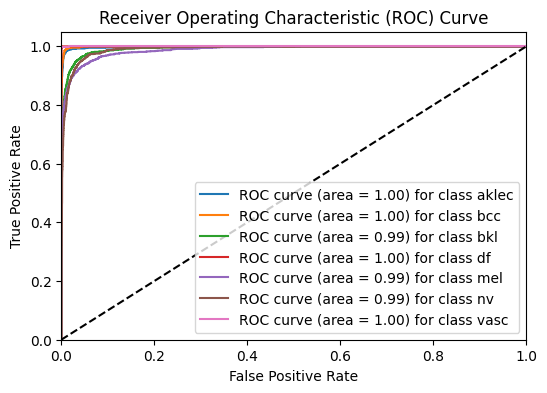

In [39]:
num_classes = 7

# Compute ROC curve and ROC area for each class
fpr_mobilenet_v2 = dict()
tpr_mobilenet_v2 = dict()
roc_auc_mobilenet_v2 = dict()

# Assuming pred_mobilenet contains probabilities and not one-hot encoded labels
for i in range(num_classes):
    fpr_mobilenet_v2[i], tpr_mobilenet_v2[i], _ = roc_curve((y_test == i).astype(int), pred_mobilenet_v2[:, i])
    roc_auc_mobilenet_v2[i] = auc(fpr_mobilenet_v2[i], tpr_mobilenet_v2[i])

# Plot ROC curve
plt.figure(figsize=(6, 4))

# Plot each class for mobilenet
for i in range(num_classes):
    plt.plot(fpr_mobilenet_v2[i], tpr_mobilenet_v2[i], label=f'ROC curve (area = {roc_auc_mobilenet_v2[i]:0.2f}) for class {classes[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### **Generate ACC & Loss Curve**

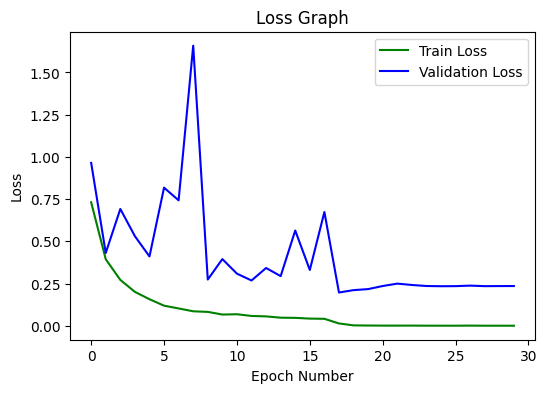

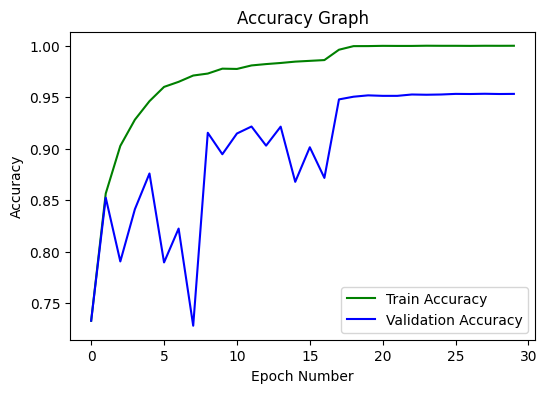

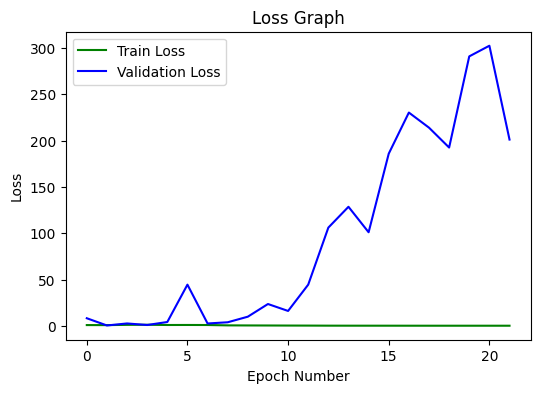

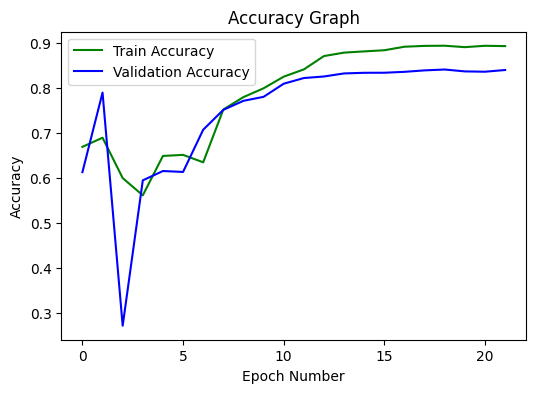

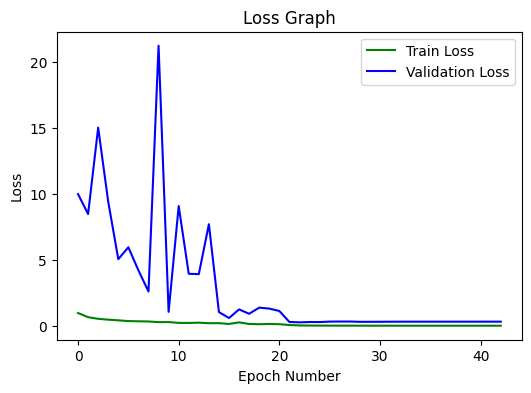

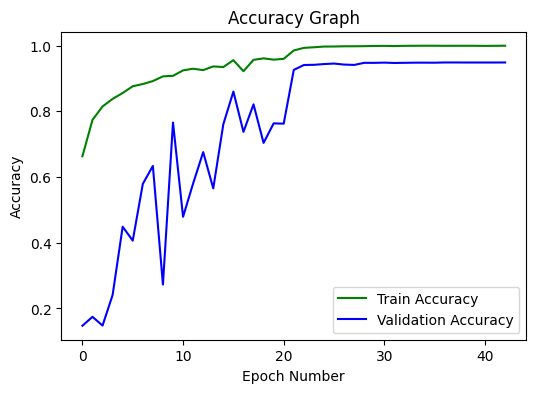

In [40]:
def show_plots(history):
  plt.subplots(figsize=(6,4))
  plt.plot(history.epoch, history.history["loss"], color="green", label="Train Loss")
  plt.plot(history.epoch, history.history["val_loss"], color="blue",
  label="Validation Loss")
  plt.xlabel("Epoch Number")
  plt.ylabel("Loss")
  plt.legend()
  plt.title("Loss Graph")
  plt.show()
  plt.subplots(figsize=(6,4))
  plt.plot(history.epoch, history.history["accuracy"], color="green",
  label="Train Accuracy")
  plt.plot(history.epoch, history.history["val_accuracy"], color="blue",
  label="Validation Accuracy")
  plt.xlabel("Epoch Number")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title("Accuracy Graph")
  plt.show()
    
show_plots(history_xception)
show_plots(history_inception_resnet_v2)
show_plots(history_mobilenet_v2)

### **GradCAM Analysis**

In [44]:
from tensorflow.keras.models import Model

def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str

    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
        # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    return heatmap

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    
    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

In [50]:
# View all Convolution Layers of all 3 models
xception_conv2D_layers = [layer.name for layer in reversed(xception_model.layers) if isinstance(layer, tf.keras.layers.Conv2D)]
inception_resnet_v2_conv2D_layers = [layer.name for layer in reversed(inception_resnet_v2_model.layers) if isinstance(layer, tf.keras.layers.Conv2D)]
mobilenet_v2_conv2D_layers = [layer.name for layer in reversed(mobilenet_v2_model.layers) if isinstance(layer, tf.keras.layers.Conv2D)]
# print(xception_conv2D_layers)
# print(inception_resnet_v2_conv2D_layers)
# print(mobilenet_v2_conv2D_layers)

In [46]:
# Function to visualize grad-cam for multiple indices of test dataset
def visualize_grad_cam_for_indices(model, images, labels, indices, layer_name):
    """
    Generate and visualize Grad-CAM heatmaps for multiple images and a specified layer.

    Args:
        model: Keras model.
        images: List or array of image data.
        labels: List or array of ground truth labels corresponding to the images.
        indices: Array of indices of the images to visualize.
        layer_name: Name of the layer for which Grad-CAM heatmaps will be generated.
    """
    plt.figure(figsize=(4 * len(indices), 4))

    for i, index in enumerate(indices):
        img = images[index]
        label = labels[index]

        grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer_name)
        grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)

        ax = plt.subplot(1, len(indices), i + 1)
        plt.imshow(grad_cam_superimposed)
        plt.axis('off')
        plt.title(f'{classes[label]} ({layer_name})', fontsize=16)

    plt.tight_layout()
    plt.show()

    
# Function to display original images for multiple indices of test dataset
def show_images_by_indices(images, labels, indices):
    """
    Display images from an array of images based on specified indices.

    Args:
        images: List or array of image data.
        indices: Array of indices of the images to display.
    """
    num_images = len(indices)
    plt.figure(figsize=(4*len(indices), 4))
    
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(classes[labels[idx]], fontsize=16)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### **Grad-CAM Visualization of Xception Model**

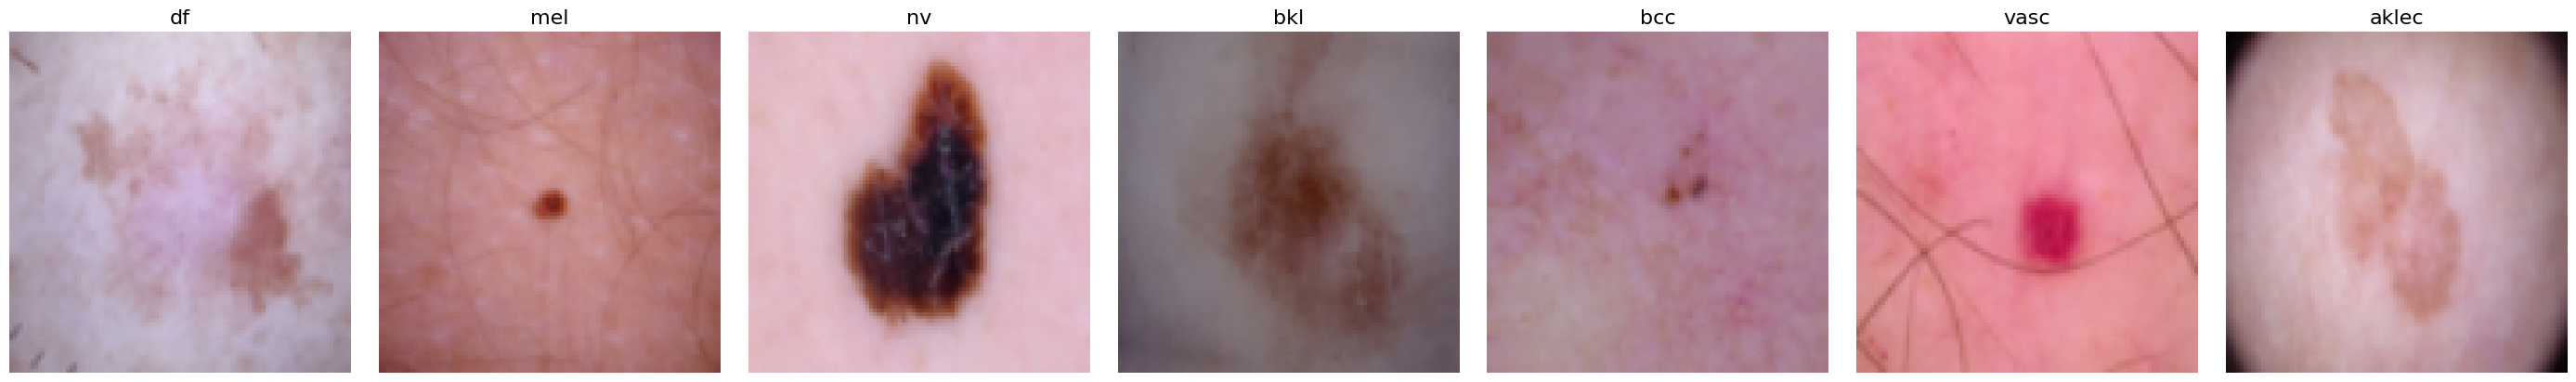

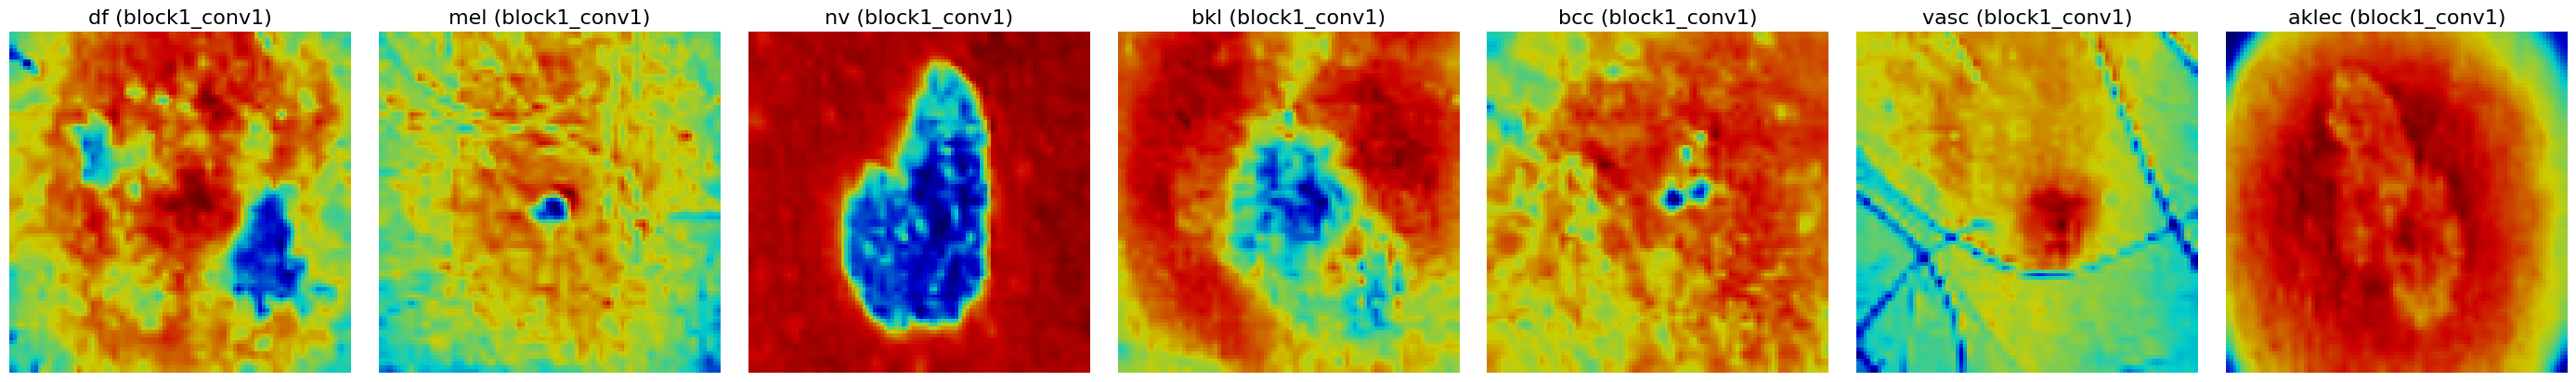

In [88]:
show_images_by_indices(x_test, y_test, [316,101,313,207,306,311,314])
visualize_grad_cam_for_indices(xception_model, x_test, y_test, [316,101,313,207,306,311,314], 'block1_conv1')


### **Grad-CAM Visualization of InceptionResNetV2 Model**

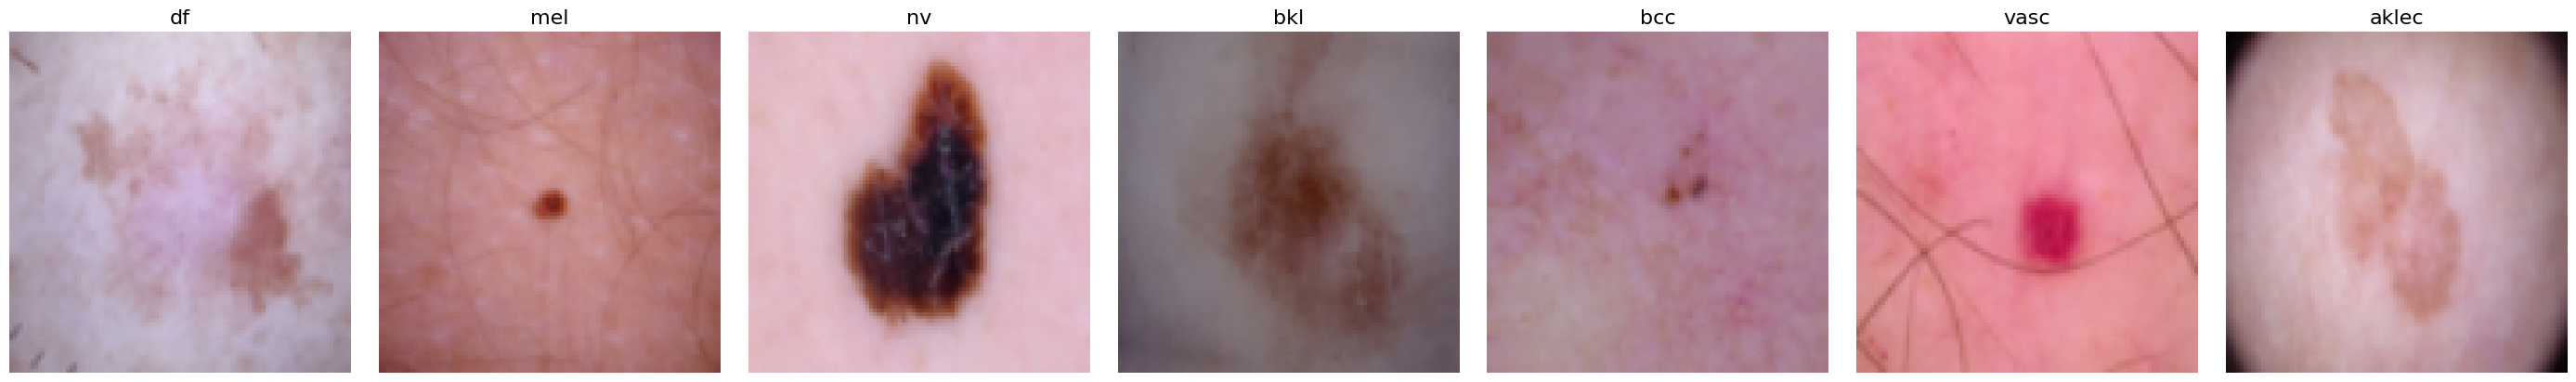

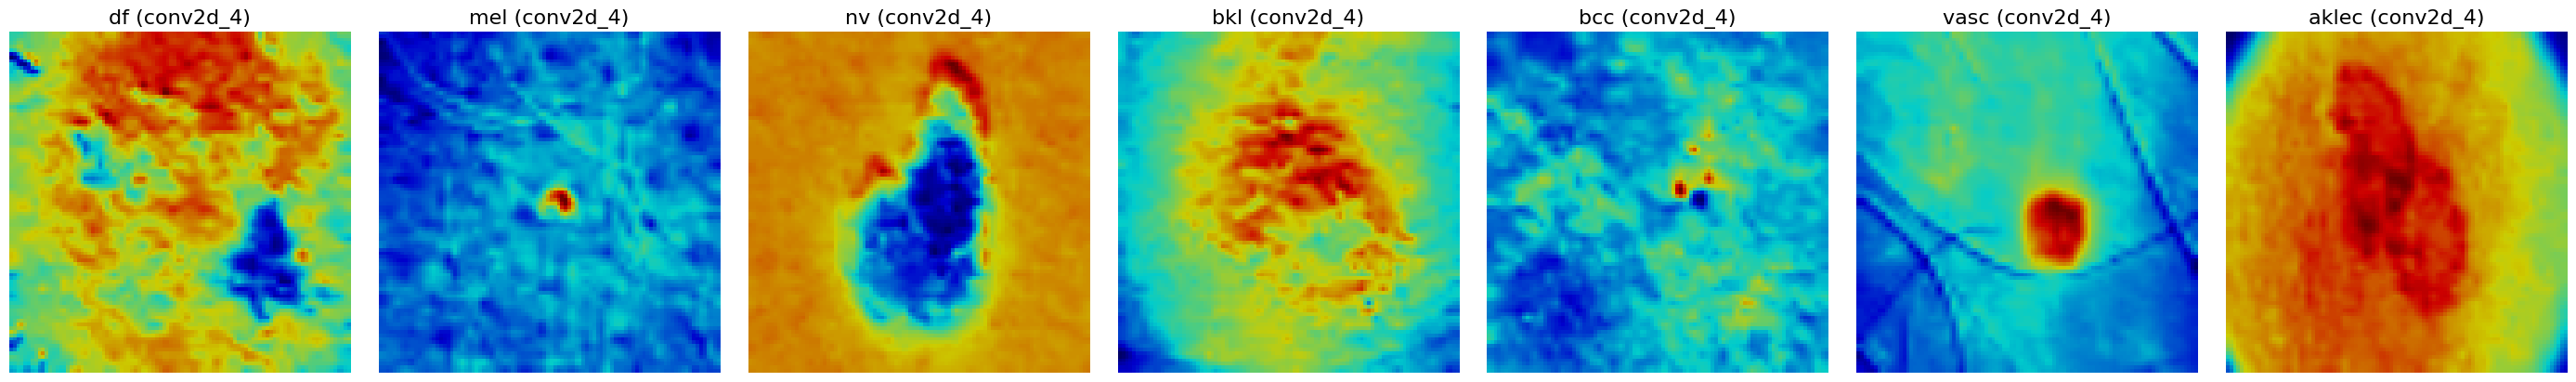

In [89]:
show_images_by_indices(x_test, y_test, [316,101,313,207,306,311,314])
visualize_grad_cam_for_indices(inception_resnet_v2_model, x_test, y_test, [316,101,313,207,306,311,314], 'conv2d_4')

### **Grad-CAM Visualization of MobileNetV2 Model**

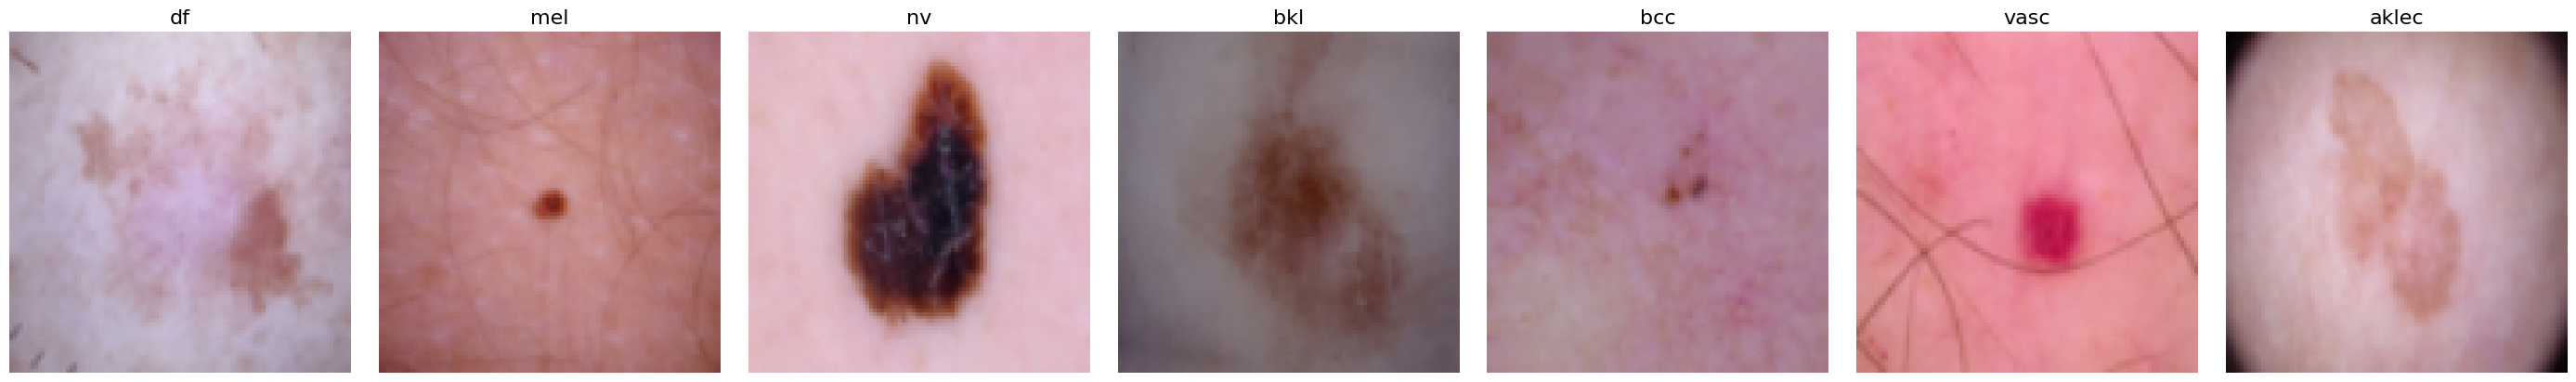

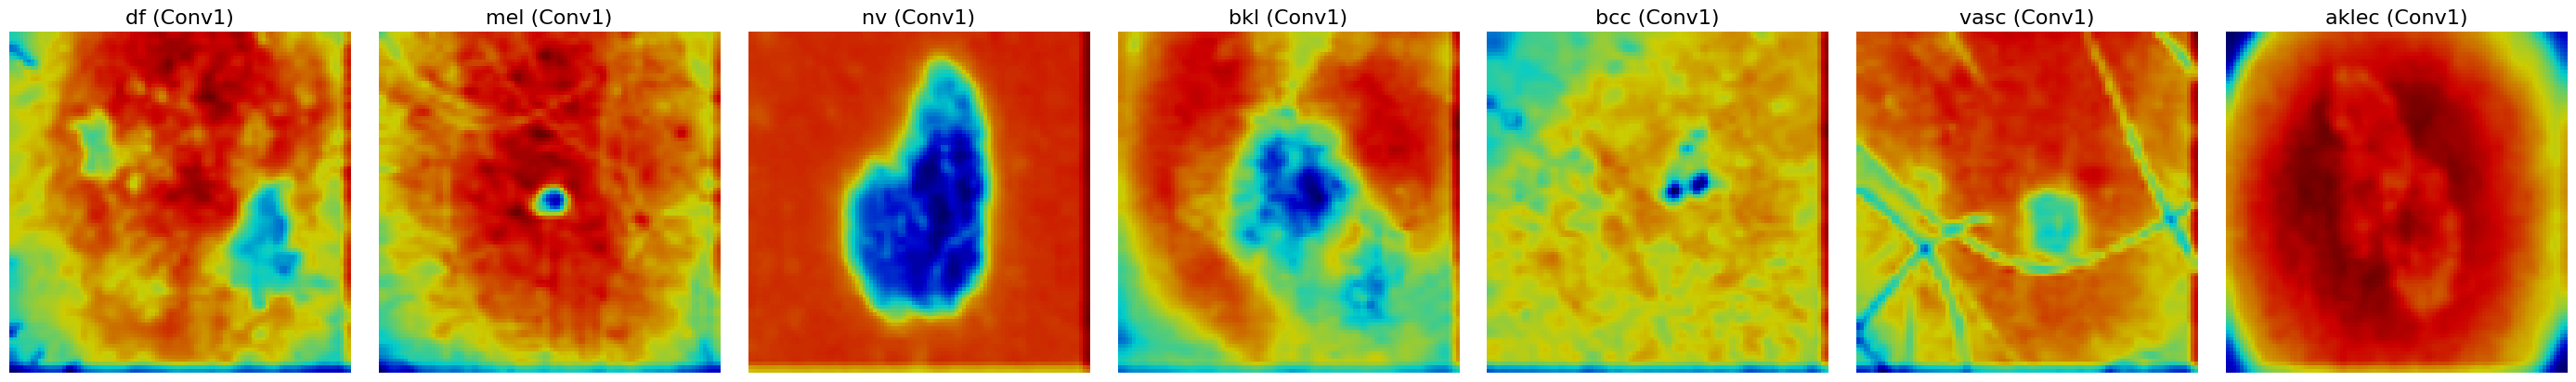

In [90]:
show_images_by_indices(x_test, y_test, [316,101,313,207,306,311,314])
visualize_grad_cam_for_indices(mobilenet_v2_model, x_test, y_test, [316,101,313,207,306,311,314], 'Conv1')